In [1]:
import torch

import numpy as np
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from sklearn.metrics.pairwise import rbf_kernel
from scipy.special import rel_entr
from transformers import AutoTokenizer

import json
import os
import random
random.seed(22)

from tqdm import tqdm

import spacy

from transformers import AutoConfig

from dataclasses import dataclass


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

save_path = 'figure'
if os.path.exists(save_path): pass
else: os.mkdir(save_path)

/home/baekig/.conda/envs/vrag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_ids_image = ["Qwen/Qwen2-VL-2B-Instruct", "Qwen/Qwen2-VL-7B-Instruct", "OpenGVLab/InternVL2-8B" ]
model_ids_text = ["Qwen/Qwen2-VL-2B-Instruct", "Qwen/Qwen2-VL-7B-Instruct", "OpenGVLab/InternVL2-8B"]
model_ids_text_llm = ["Qwen/Qwen2-1.5B", "Qwen/Qwen2-7B", "internlm/internlm2_5-7b-chat"]

tasks = ["image", 'text']
total_layer_head = {}
for model_id in sum([model_ids_image, model_ids_text_llm], []):
    config = AutoConfig.from_pretrained(model_id, trust_remote_code=True)
    if "internlm" in model_id.lower():
        n_heads = config.num_attention_heads # 10
        n_layer = config.num_hidden_layers # 12
    elif 'intern' in model_id.lower():
        n_heads = config.llm_config.num_attention_heads
        n_layer = config.llm_config.num_hidden_layers
    else:
        n_heads = config.num_attention_heads # 10
        n_layer = config.num_hidden_layers # 12
    total_layer_head[f"{model_id}"] = [n_layer, n_heads]
##
image_2b_path_all_fg = "retrieval_score/image/Qwen2-VL-2B-Instruct_fg_2.json"
image_7b_path_all_fg = "retrieval_score/image/Qwen2-VL-7B-Instruct_fg_2.json"
image_8b_path_all_fg = "retrieval_score/image/InternVL2-8B_fg_2.json"
paths_image_all = [image_2b_path_all_fg, image_7b_path_all_fg, image_8b_path_all_fg]

dataset_image_all = []
for path in paths_image_all:
    with open(path, 'r') as f:
        data = json.load(f)
    dataset_image_all.append(data)

text_2b_path_all = "retrieval_score/text/Qwen2-VL-2B-Instruct_te_2.json"
text_7b_path_all = "retrieval_score/text/Qwen2-VL-7B-Instruct_te_2.json"
text_8b_path_all = "retrieval_score/text/InternVL2-8B_te_2.json"
paths_text_all = [text_2b_path_all, text_7b_path_all, text_8b_path_all]

'''image_2b_path_all_fg = "retrieval_score/image/Qwen2-VL-2B-Instruct_fg_2.json"
image_7b_path_all_fg = "retrieval_score/image/Qwen2-VL-7B-Instruct_fg_2.json"
image_8b_path_all_fg = "retrieval_score/image/InternVL2-8B_fg_2.json"
paths_image_all = [image_2b_path_all_fg, image_7b_path_all_fg, image_8b_path_all_fg]

dataset_image_all = []
for path in paths_image_all:
    with open(path, 'r') as f:
        data = json.load(f)
    dataset_image_all.append(data)

text_2b_path_all = "retrieval_score/text/Qwen2-VL-2B-Instruct_te_2.json"
text_7b_path_all = "retrieval_score/text/Qwen2-VL-7B-Instruct_te_2.json"
text_8b_path_all = "retrieval_score/text/InternVL2-8B_te_2.json"
paths_text_all = [text_2b_path_all, text_7b_path_all, text_8b_path_all]'''

dataset_text_all = []
for path in paths_text_all:
    with open(path, 'r') as f:
        data = json.load(f)
    dataset_text_all.append(data)

In [3]:
def retrun_mean_dataset(dataset_all, model_image, total_layer_head = total_layer_head):
    mean_list = []
    for num, data in tqdm(enumerate(dataset_all)):
        layers, heads = total_layer_head[model_image[num]]    
        default_dictionary = {}
        
        for layer in range(layers):
            for head in range(heads):
                default_dictionary[f'l{layer}_h{head}'] = 0
                
        for layer in range(layers):
            for head in range(heads):
                _t = torch.tensor(dataset_all[num][f'l{layer}_h{head}'])
                if sum(torch.where(_t != 0, 0, 1)) > 0.1 * len(data[f'l{layer}_h{head}']):
                    default_dictionary[f'l{layer}_h{head}'] = sum(data[f'l{layer}_h{head}'])/len(data[f'l{layer}_h{head}'])
                else:
                    default_dictionary[f'l{layer}_h{head}'] = 0
        mean_list.append(default_dictionary)
    return mean_list
image_mean_list = retrun_mean_dataset(dataset_image_all, model_ids_image)
text_mean_list = retrun_mean_dataset(dataset_text_all, model_ids_text)

qwen_15_path = "/home/baekig/adaptive_vrag/retrieval_head/retrieval_score/text/Qwen2-1.5B.json"
qwen_7_path = "/home/baekig/adaptive_vrag/retrieval_head/retrieval_score/text/Qwen2-7B.json"
intern_7b_path = "/home/baekig/adaptive_vrag/retrieval_head/retrieval_score/text/internlm2_5-7b-chat.json"
model_ids_text_llm = ["Qwen/Qwen2-1.5B", "Qwen/Qwen2-7B", "internlm/internlm2_5-7b-chat"]
dataset_text_all_llm= []
paths_text_all_llm = [qwen_15_path, qwen_7_path, intern_7b_path ]

for path in paths_text_all_llm:
    with open(path, 'r' ) as f:
        data = json.load(f)
    dataset_text_all_llm.append(data)
    
text_mean_list_llm = retrun_mean_dataset(dataset_text_all_llm, model_ids_text_llm)

3it [00:04,  1.56s/it]
3it [00:02,  1.06it/s]
3it [00:01,  1.61it/s]


In [4]:
def make_bd(image_mean):
    keys = ['0', '1', '2', '3', '4']
    boundary_dict = {key: [] for key in keys} 

    for key, value in image_mean.items():
        if value ==0:
            boundary_dict['0'].append(key)
        elif (value > 0) and (value < 0.1):
            boundary_dict['1'].append(key)
        elif (value >= 0.1) and (value < 0.3):
            boundary_dict['2'].append(key)
        elif (value >= 0.3) and (value < 0.5):
            boundary_dict['3'].append(key)
        elif (value >= 0.5) and (value <= 1.0):
            boundary_dict['4'].append(key)
    return boundary_dict

image_boundary_dict_list, text_boundary_dict_list, text_boundary_dict_list_llm = [], [], []
for num in range(len(image_mean_list)):
    boundary_dict = make_bd(image_mean_list[num])
    image_boundary_dict_list.append(boundary_dict)
    
for num in range(len(text_mean_list)):
    boundary_dict = make_bd(text_mean_list[num])
    text_boundary_dict_list.append(boundary_dict)
    
for num in range(len(text_mean_list_llm)):
    boundary_dict = make_bd(text_mean_list_llm[num])
    text_boundary_dict_list_llm.append(boundary_dict)

In [5]:
for img_mean in image_mean_list:
    count = 0
    for key, value in img_mean.items():
        if value > 0.1:
            count += 1
    print(count)
for text_mean in text_mean_list:
    count = 0
    for key, value in text_mean.items():
        if value > 0.1:
            count += 1
    print(count)

55
68
44
40
24
34


In [6]:
def jaccard_similarity(set1, set2):
    if not set1 and not set2:
        return 0.0 
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union

[52.083333333333336, 42.26190476190476, 4.166666666666666, 1.488095238095238, 0.0]
0
[72.83163265306123, 22.193877551020407, 4.209183673469387, 0.7653061224489796, 0.0]
1
[78.7109375, 18.359375, 1.3671875, 1.07421875, 0.48828125]
2
[63.095238095238095, 20.535714285714285, 6.845238095238096, 6.547619047619048, 2.976190476190476]
[75.38265306122449, 15.943877551020408, 4.846938775510204, 2.806122448979592, 1.0204081632653061]
[87.40234375, 8.30078125, 3.125, 0.5859375, 0.5859375]


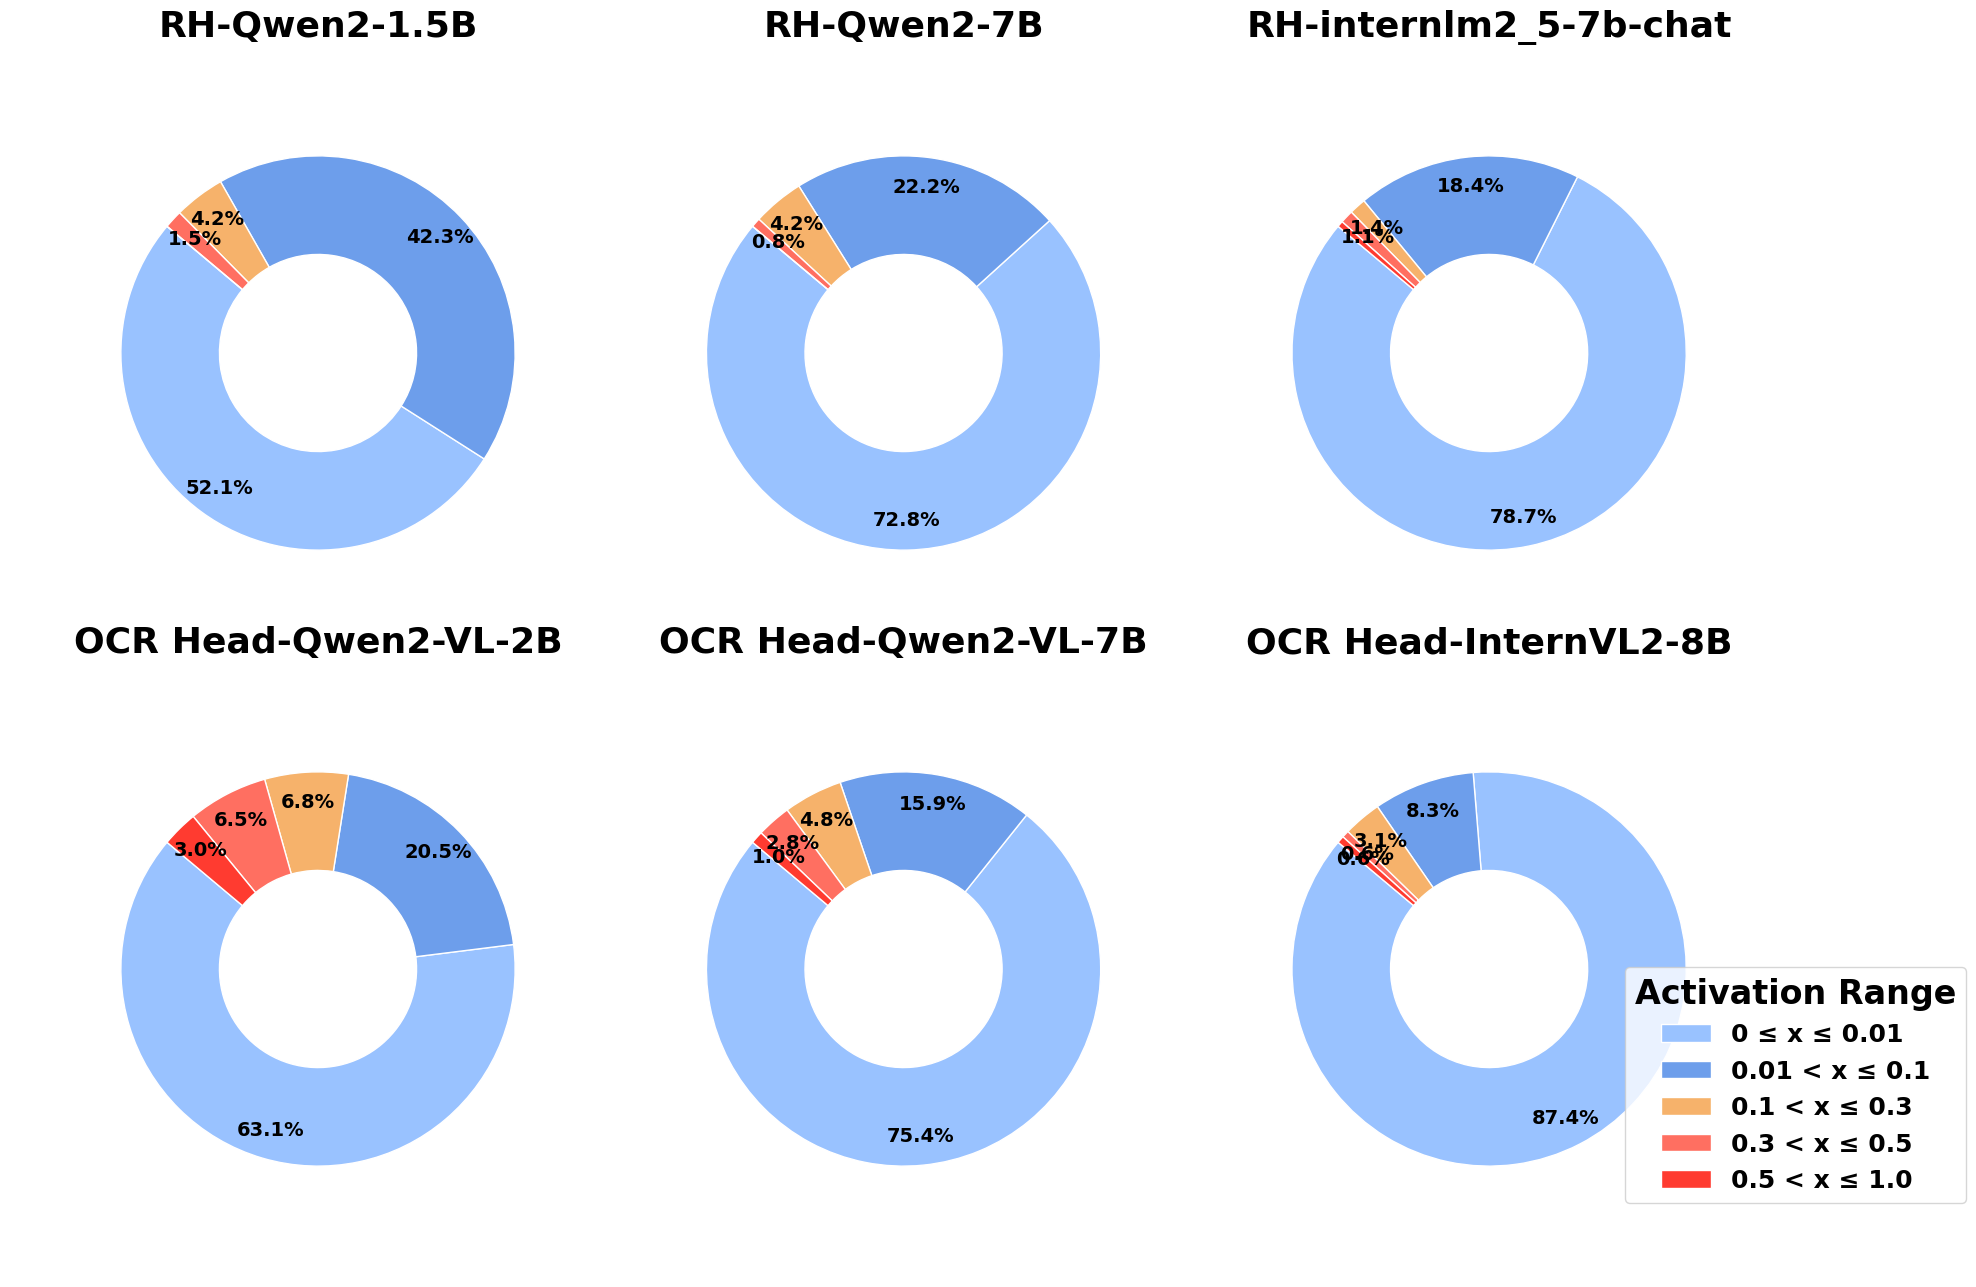

In [7]:
labels = ['0 ≤ x ≤ 0.01', '0.01 < x ≤ 0.1', '0.1 < x ≤ 0.3', '0.3 < x ≤ 0.5', '0.5 < x ≤ 1.0']
colors = ["#99c2ff", "#6d9eeb", "#f6b26b", "#ff6f61", "#ff3b30"]

fig, axes = plt.subplots(2, 3, figsize=(24, 16))


for i, model in enumerate(sum([model_ids_text_llm, model_ids_image], [])):
    count0, count01,count03, count05, count1  = [], [], [], [], []
    i_name = {0:0, 1:1, 2:2, 3:0, 4:1, 5:2}
    
    axes0 = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1}
    axes1 = {0:0, 1:1, 2:2, 3:0, 4:1, 5:2}
    
    if i ==0 or i == 1 or i == 2: mean_list = text_mean_list_llm
    else: mean_list = image_mean_list
    
    for j in mean_list[i_name[i]].values():
        if j == 0: count0.append(1)
        elif (j>0) and (j<=0.1): count01.append(1)
        elif (j>0.1) and (j<=0.3): count03.append(1)
        elif (j>0.3) and (j<=0.5): count05.append(1)
        elif (j>0.5) and (j<=1): count1.append(1)

    data = [len(count0), len(count01), len(count03), len(count05), len(count1)]
    total = sum(data)
    percentages = [(c / total) * 100 for c in data]
    print(percentages)
    def autopct_func(pct):
        return ('%.1f%%' % pct) if pct > 0.5 else ''
    wedges, _, autotexts = axes[axes0[i]][axes1[i]].pie(
        percentages,
        colors=colors,
        startangle=140,
        pctdistance=0.85,
        radius=0.8,
        wedgeprops=dict(width=0.4, edgecolor="w"),
        autopct=autopct_func,
    )
    
    if (i ==0) or (i == 1) or (i == 2): 
        print(i)
        title_name = "RH-" + model.split('/')[1].replace("-Instruct", "")
    else: title_name = "OCR Head-" + model.split('/')[1].replace("-Instruct", "")
    
    plt.setp(autotexts, size=14, weight="bold")

    if i == 5:
        legend = axes[axes0[i]][axes1[i]].legend(
            wedges, labels, 
            title="Activation Range", 
            loc="lower left", bbox_to_anchor=(0.7, 0.1), 
            prop={'weight': 'bold', 'size': 18},  
            title_fontsize=24
        )
        legend.get_title().set_fontweight('bold')
    # plt.tight_layout()
    axes[axes0[i]][axes1[i]].set_title(title_name, fontsize=26, fontweight="bold")
plt.subplots_adjust(hspace=0.0, wspace=-0.15)
plt.show()

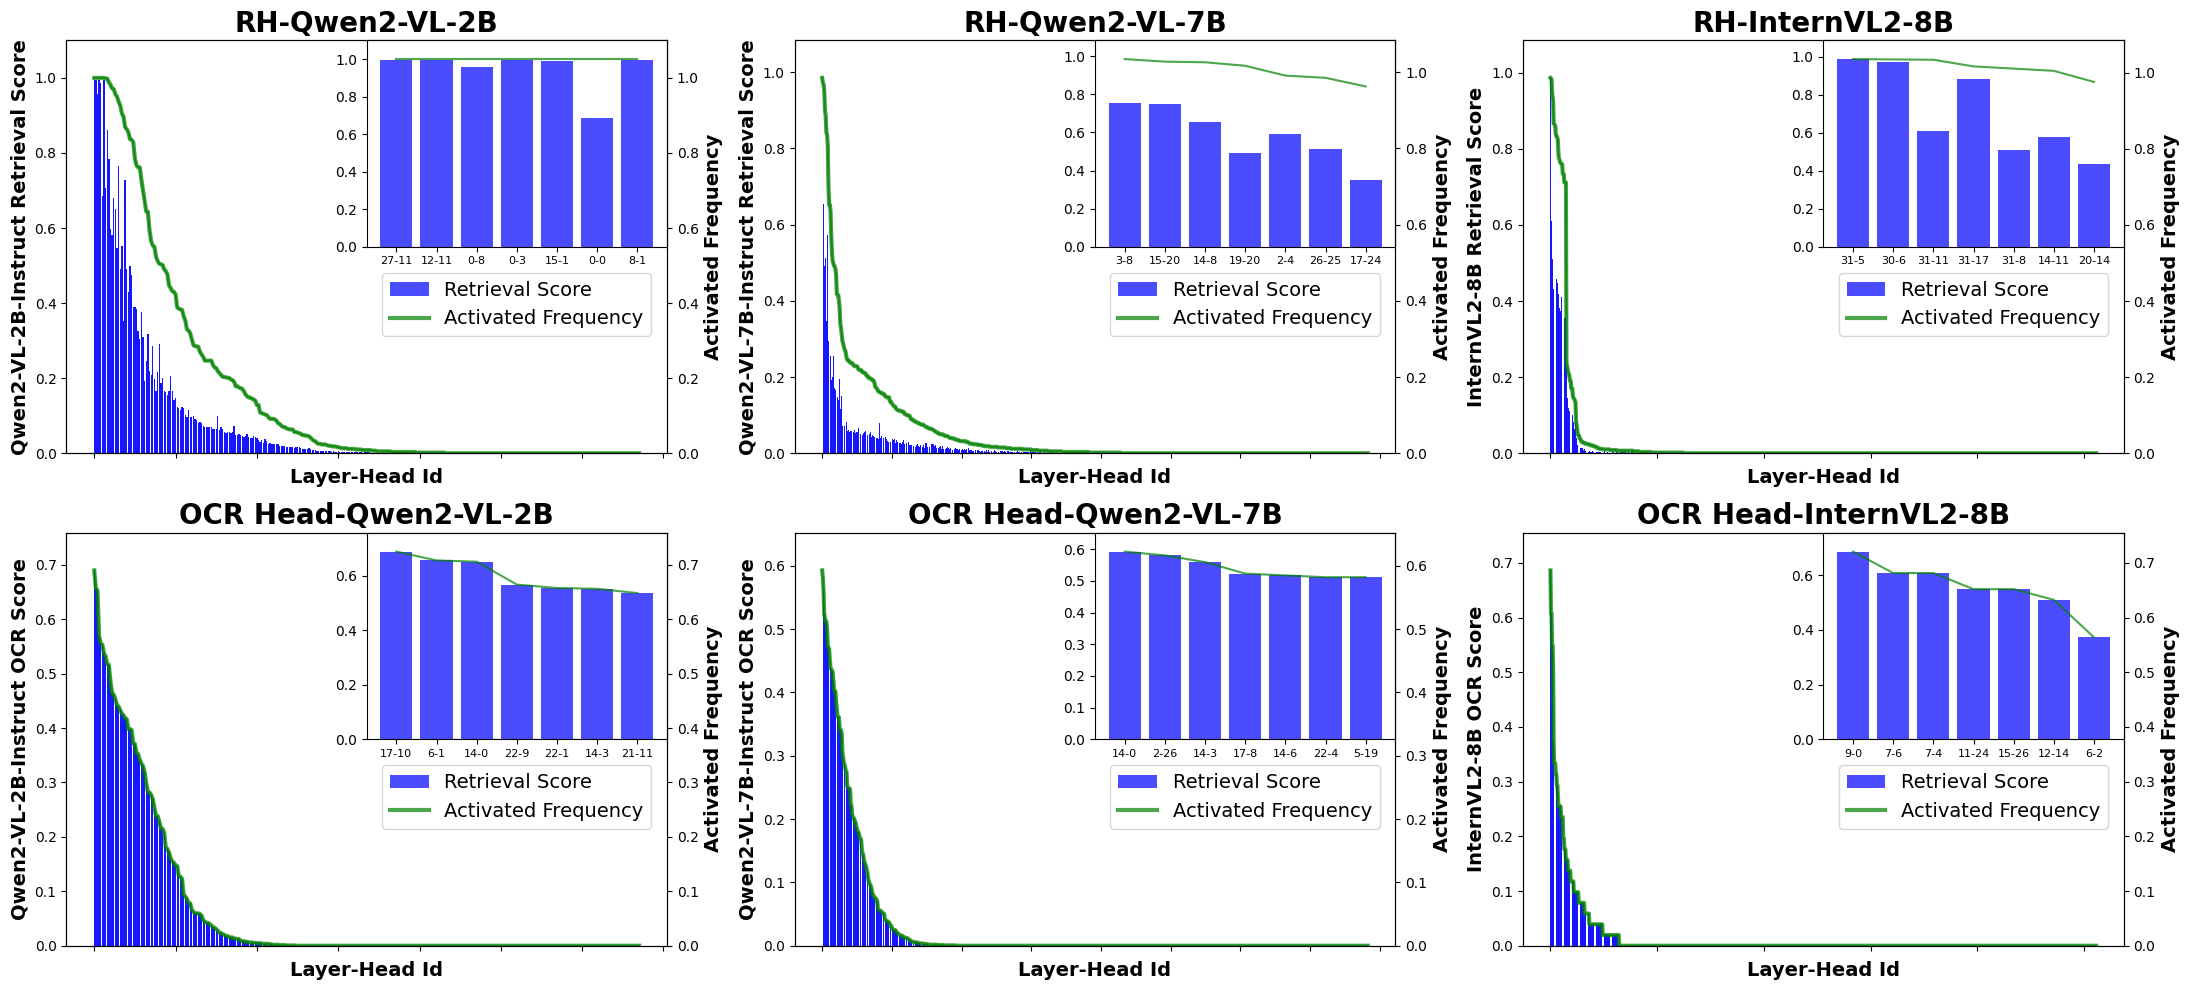

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(22, 10))
axes = axes.flatten()

for i, (data_all, mean_list) in enumerate(zip(
    sum([dataset_text_all, dataset_image_all], []),
    sum([text_mean_list, image_mean_list], []),
)):
    data_all_avg = {}
    activation_frequency = {}
    activation_frequency_mean = []
    
    for key in data_all.keys():
        activation_frequency[key] = [1 if val > 0.1 else 0 for val in data_all[key]]
        data_all_avg[key] = np.mean(data_all[key])
        
    keys = [key.replace('l', '').replace('h', '').replace('_', '-') for key in data_all.keys()]
    activation_frequency_mean = [np.mean(value) for value in activation_frequency.values()]
    
    sorted_indices = np.argsort(activation_frequency_mean)[::-1]
    retrieval_scores = np.array(list(data_all_avg.values()))[sorted_indices]
    activation_counts = np.array(activation_frequency_mean)[sorted_indices]
    layer_heads = np.array(keys)[sorted_indices]
    
    ax = axes[i]
    ax2 = ax.twinx()

    ax.bar(range(len(retrieval_scores)), retrieval_scores, color='blue', label='Retrieval Score', alpha=0.7)
    ax2.plot(range(len(activation_counts)), activation_counts, color='green', label='Activated Frequency', alpha=0.7)
    
    ax2.set_ylim(0, max(activation_counts) * 1.1)
    ax.set_ylim(0, max(activation_counts) * 1.1)

    ax.set_xlabel("Layer-Head Id", fontweight='bold', fontsize=14)
    ax.set_xticklabels([])
    if (i ==0) or (i == 1) or (i == 2): 
        ax.set_ylabel(f"{sum([model_ids_text, model_ids_image], [])[i].split('/')[1]} Retrieval Score", fontweight="bold", fontsize=14)
    else:
        ax.set_ylabel(f"{sum([model_ids_text, model_ids_image], [])[i].split('/')[1]} OCR Score", fontweight="bold", fontsize=14)
    ax2.set_ylabel("Activated Frequency", fontweight="bold", fontsize=14)
    
    if (i ==0) or (i == 1) or (i == 2): 
        title_name = "RH-" + model_ids_text[i].split('/')[1].replace("-Instruct", "")
    else: title_name = "OCR Head-" + model_ids_image[i-3].split('/')[1].replace("-Instruct", "")
    
    ax.set_title(title_name, fontsize=20, fontweight='bold')
    
    bar = ax.bar(range(len(retrieval_scores)), retrieval_scores, color='blue', label='Retrieval Score', alpha=0.7)
    line, = ax2.plot(range(len(activation_counts)), activation_counts, color='green', label='Activated Frequency', alpha=0.7, linewidth=3)

    inset_ax = ax.inset_axes([0.5, 0.5, 0.5, 0.5])
    inset_indices = sorted_indices[:7]
    inset_ax.bar(range(len(inset_indices)), retrieval_scores[:7], color='blue', alpha=0.7)
    inset_ax.plot(range(len(inset_indices)), activation_counts[:7], color='green', alpha=0.7)
    inset_ax.set_xticks(range(len(inset_indices)))
    inset_ax.set_xticklabels(layer_heads[:7], fontsize=8)

    inset_ax.set_ylim(0, max(activation_counts[:7]) * 1.1)

    ax.legend(handles=[bar, line], loc='lower right', fontsize=14, bbox_to_anchor=(0.99, 0.26))

plt.tight_layout()
plt.show()

Qwen/Qwen2-VL-2B-Instruct
Qwen/Qwen2-VL-7B-Instruct
OpenGVLab/InternVL2-8B


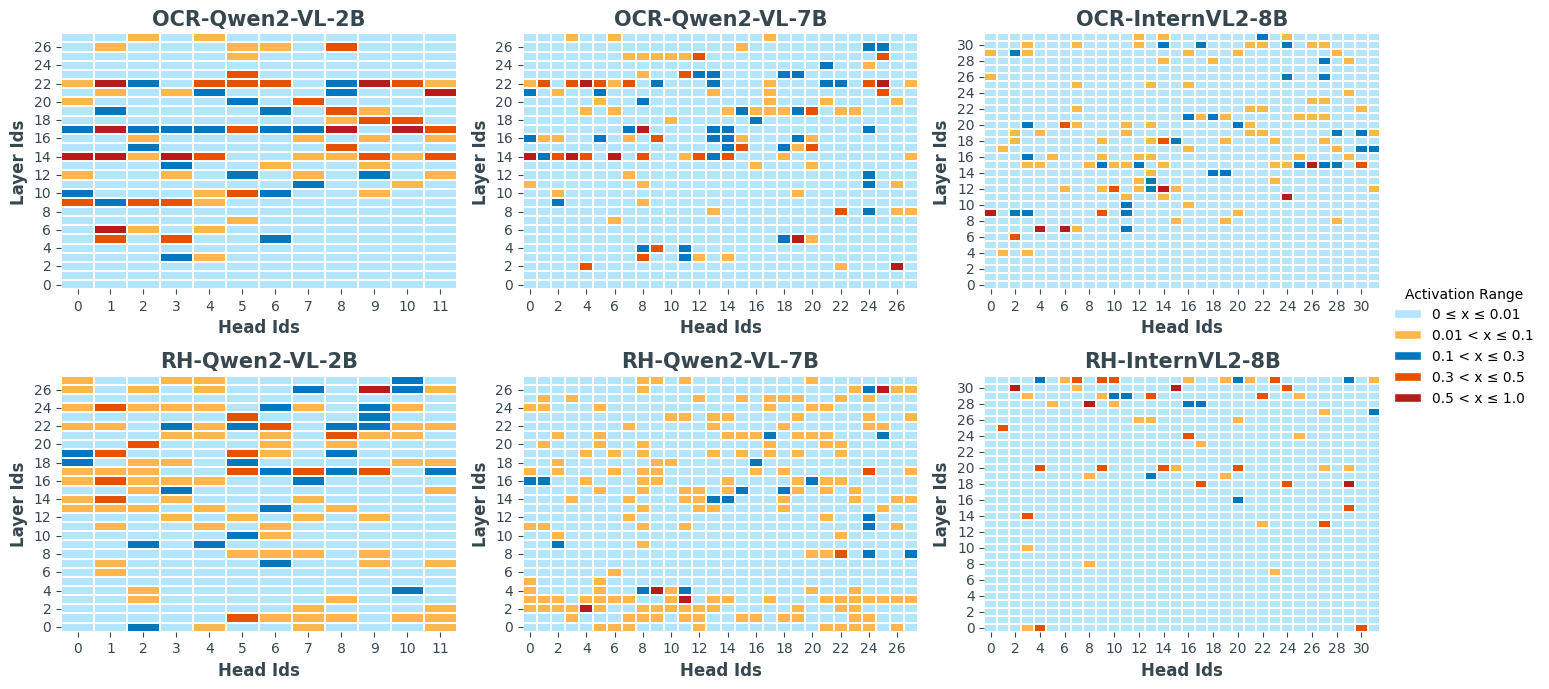

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

colors = ["#B3E5FC", "#FFB74D", "#0277BD" , "#E65100", "#B71C1C"]
bounds = [0.0,0.01,0.1, 0.3, 0.5, 1.0]  
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes = axes.flatten()

for i, (model, model_activation) in enumerate(zip(
    sum([model_ids_image, model_ids_text], []),
    sum([image_mean_list, text_mean_list], []),
)): 
    
    layers, heads = total_layer_head[model]

    activation_values = np.zeros((layers, heads))

    for key, value in model_activation.items():
        layer_id, head_id = map(int, key[1:].split('_h'))
        if layer_id < layers and head_id < heads:
            activation_values[layer_id, head_id] = value

    sns.heatmap(
        activation_values, ax=axes[i], cmap=cmap, norm=norm,
        cbar=False, linewidths=0.3, linecolor="white"
    )

    if (i == 0 or i == 1 or i ==2): 
        print(model)
        axes[i].set_title("OCR-" + model.split('/')[1].replace("-Instruct", ""), fontsize=15, fontweight="bold", color="#37474F")
    else: 
        axes[i].set_title("RH-" + model.split('/')[1].replace("-Instruct", ""), fontsize=15, fontweight="bold", color="#37474F")
    
    axes[i].set_xlabel("Head Ids", fontsize=12, color="#37474F", fontweight="bold")
    axes[i].set_ylabel("Layer Ids", fontsize=12, color="#37474F", fontweight="bold")
    axes[i].tick_params(axis='both', labelsize=10, colors="#37474F", rotation=0)
    axes[i].invert_yaxis()

legend_elements = [
    Patch(facecolor="#B3E5FC", edgecolor='white', label='0 ≤ x ≤ 0.01'),
    Patch(facecolor="#FFB74D", edgecolor='white', label='0.01 < x ≤ 0.1'),
    Patch(facecolor="#0277BD", edgecolor='white', label='0.1 < x ≤ 0.3'),
    Patch(facecolor="#E65100", edgecolor='white', label='0.3 < x ≤ 0.5'),
    Patch(facecolor="#B71C1C", edgecolor='white', label='0.5 < x ≤ 1.0'),
]

fig.legend(handles=legend_elements, title='Activation Range',loc='upper left', bbox_to_anchor=(0.99, 0.6), frameon=False)

plt.tight_layout()
plt.show()